In [ ]:
!pip install transformers
!pip install torch
!pip install evaluate
!pip install rouge-score
!pip install bert_score
!pip install datasets transformers[sentencepiece]
!pip install sentencepiece

In [5]:
!git clone https://github.com/recitalAI/summa-qa.git
!cd summa-qa
!pip install -e .

"git" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


Obtaining file:///C:/Users/victor/IAD_course_project/pythonProject


ERROR: file:///C:/Users/victor/IAD_course_project/pythonProject does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
os.environ["HF_TOKEN"] = ""

In [2]:
from datasets import load_metric
from summaqa import QA_Metric
from summaqa import QG_masked
import nltk

# Загрузка необходимых ресурсов для NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Импорт метрик
rouge = load_metric('rouge')
bleu = load_metric('bleu')
meteor = load_metric('meteor')
bertscore = load_metric('bertscore')
summa_qa = QA_Metric()
summa_qa_question_generator = QG_masked()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\victor\AppData\Local\Temp\ipykernel_8068\1881818018.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric('rouge')
C:\Users\victor\IAD_course_project\pythonProject\.venv\lib\site-packages\datasets\load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the reposi

In [3]:
def evaluate_metrics(predictions, references, article, metrics):
    # Преобразование текстов для BLEU метрики
    bleu_predictions = [prediction.split() for prediction in predictions]
    bleu_references = [[reference.split()] for reference in references]
    
    results = {}
    
    for metric in metrics:
        if metric == "bleu":
            results["bleu"] = bleu.compute(predictions=bleu_predictions, references=bleu_references)
        elif metric == "bertscore":
            results["bertscore"] = bertscore.compute(predictions=predictions, references=references, lang='en')
        elif metric == "summa_qa":
            masked_questions, answer_spans = summa_qa_question_generator.get_questions(article)
            print(predictions[0])
            results[metric] = summa_qa.compute(masked_questions, answer_spans, predictions[0])
        else:
            results[metric] = globals()[metric].compute(predictions=predictions, references=references)
    
    return results

In [4]:
import torch
from openai import OpenAI
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # 1. OpenAI GPT-4 (через API)
# 
# client = OpenAI(
#     # This is the default and can be omitted
#     api_key='',
# )
# 
# def summarize_with_gpt4(text):
#     response = client.chat.completions.create(
#       model="gpt-4",
#       messages=[{"role": "user", "content": f"Summarize the following text:\n\n{text}"},],
#       max_tokens=150
#     )
#     return response.choices[0].message.content.strip()

# 2. Google T5 Large
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
t5_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
t5_model.to(device)

def summarize_with_t5(text):
    inputs = t5_tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True).to(device)
    outputs = t5_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

# 3. Facebook BART Large CNN
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
bart_model.to(device)

def summarize_with_bart(text):
    inputs = bart_tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True).to(device)
    summary_ids = bart_model.generate(inputs, max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 4. Google Pegasus XSum
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-xsum")
pegasus_model.to(device)

def summarize_with_pegasus(text):
    inputs = pegasus_tokenizer(text, return_tensors="pt", truncation=True, padding="longest").to(device)
    summary_ids = pegasus_model.generate(inputs["input_ids"], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 5. Meta Llama 3 8B Instruct (используем AutoModelForCausalLM)
llama_tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
llama_model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16)
llama_model.to(device)

def summarize_with_llama(text):
    llama_tokenizer.pad_token = llama_tokenizer.eos_token
    inputs = llama_tokenizer(text, return_tensors="pt", truncation=True, padding="longest").to(device)
    terminators = [
        llama_tokenizer.eos_token_id,
        llama_tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    
    summary_ids = llama_model.generate(inputs["input_ids"], 
                                       max_new_tokens=256, 
                                       eos_token_id=terminators,
                                       do_sample=True,
                                       temperature=0.6,
                                       top_p=0.9,
                                       )
    return llama_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# # 6. Mistral 7B Instruct v0.3 (используем AutoModelForCausalLM)
mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
mistral_model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
mistral_model.to(device)

def summarize_with_mistral(text):
    inputs = mistral_tokenizer(text, return_tensors="pt", truncation=True, padding="longest")
    terminators = [
        llama_tokenizer.eos_token_id,
        llama_tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    summary_ids = mistral_model.generate(inputs["input_ids"], 
                                       max_new_tokens=256, 
                                       eos_token_id=terminators,
                                       do_sample=True,
                                       temperature=0.6,
                                       top_p=0.9,
                                       )
    return mistral_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def summarize_with(model, text):
    return globals()[f"summarize_with_{model}"](text)

In [6]:
import nltk
def multi_level_summarization(text, summarization_func, chunk_size=100):
    # Разделение текста на предложения
    sentences = nltk.sent_tokenize(text)
    # Разбиение предложений на куски заданного размера
    chunks = [' '.join(sentences[i:i + chunk_size]) for i in range(0, len(sentences), chunk_size)]
    # Суммаризация каждого куска
    chunk_summaries = [summarization_func(chunk) for chunk in chunks]
    # Объединение суммарий кусков
    combined_summary = ' '.join(chunk_summaries)
    # Суммаризация объединенных суммарий
    final_summary = summarization_func(combined_summary)
    
    return final_summary

In [7]:
from datasets import load_dataset

# Загрузка датасета CNN/DailyMail
cnn_dailymail = load_dataset("cnn_dailymail", "3.0.0")

In [ ]:
import json
from tqdm import tqdm
import multiprocessing as mp
from functools import partial

models = [
    "t5", "bart", "pegasus", 
    "llama", 
    "mistral"
]
heuristics = ["multi_level_summarization"]
metrics = ["rouge", "bleu", "meteor", "bertscore"]
datasets = ["cnn_dailymail"]

def process_row(row, dataset_name, model, heuristic):
    # Получение суммаризации
    summarization = globals()[heuristic](row["article"], globals()[f"summarize_with_{model}"])

    # Вычисление метрик
    results = evaluate_metrics([summarization], [row["highlights"]], row["article"], metrics)

    # Сохранение результатов
    output_data = {
        "dataset": dataset_name,
        "model": model,
        "heuristic": heuristic,
        "article": row["article"],
        "highlights": row["highlights"],
        "summarization": summarization,
        "results": results
    }

    with open(f"results1.json", "a") as f:
        f.write(json.dumps(output_data) + "\n")

def process_model(dataset_name, model, heuristic):
    dataset = globals()[dataset_name]
    with mp.Pool(processes=mp.cpu_count()) as pool:
        process_row_partial = partial(process_row, dataset_name=dataset_name, model=model, heuristic=heuristic)
        list(tqdm(pool.imap(process_row_partial, dataset["test"]), total=len(dataset["test"]), desc=f"Processing {dataset_name} with {model} and {heuristic}"))

if __name__ == "__main__":
    for dataset_name in datasets:
        for model in models:
            for heuristic in heuristics:
                process_model(dataset_name, model, heuristic)

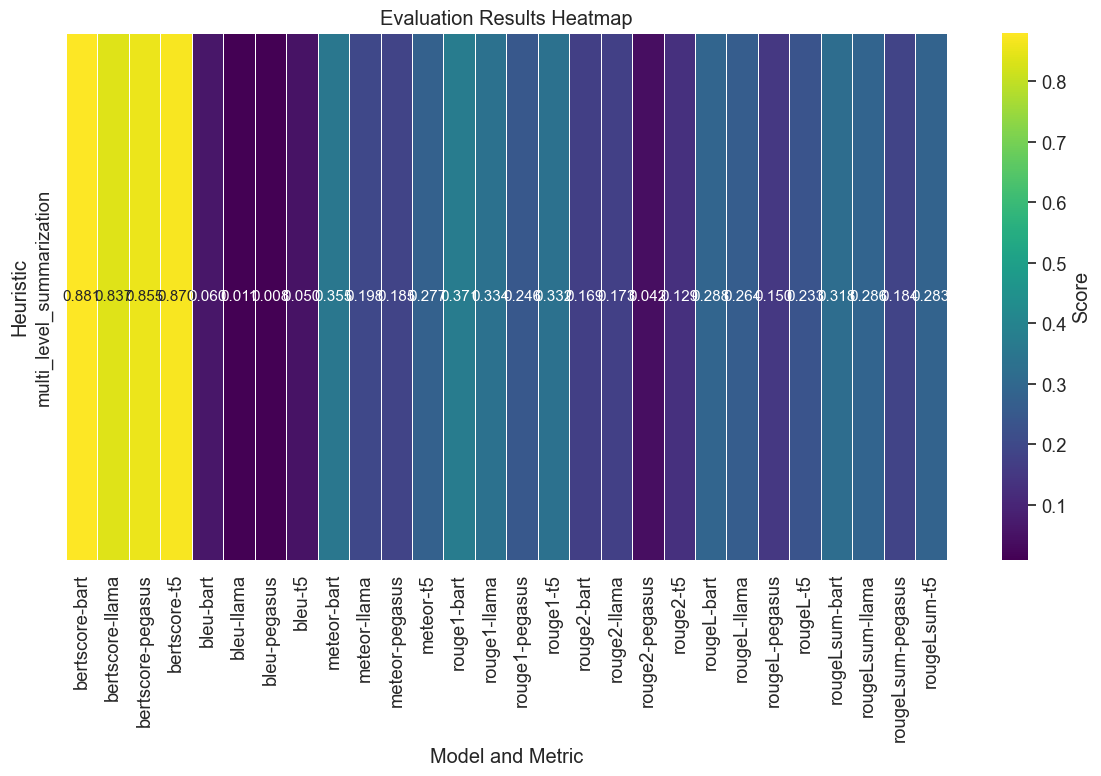

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Чтение JSON-файла в DataFrame
df = pd.read_json('results1.json', lines=True)

# Выделение нужных столбцов
df_plot = df[['model', 'heuristic', 'results']]

df_plot = pd.concat([df_plot.drop(['results'], axis=1), df_plot['results'].apply(pd.Series)], axis=1)
df_plot = pd.concat([df_plot.drop(['rouge'], axis=1), df_plot['rouge'].apply(pd.Series)], axis=1)


# Преобразование данных для удобства визуализации
df_plot = df_plot.melt(id_vars=['model', 'heuristic'], 
                       value_vars=['bleu', 'meteor', 'bertscore', 
                                   'rouge1', 'rouge2', 'rougeL', 'rougeLsum'], 
                       var_name='metric', value_name='score')
z = {
    "bleu": "bleu", 
    "meteor": "meteor", 
    "bertscore": "f1",
    "rouge1": lambda x: sum(x[0]) / len(x[0]),
    "rouge2": lambda x: sum(x[0]) / len(x[0]),
    "rougeL": lambda x: sum(x[0]) / len(x[0]),
    "rougeLsum": lambda x: sum(x[0]) / len(x[0]),
    "summa_qa": "avg_fscore",
}

df_plot['score'] = df_plot.apply(
    lambda row: z[row['metric']](row['score']) if row['metric'].startswith('rouge') else 
    row['score'][z[row['metric']]] if isinstance(row['score'], dict) and isinstance(row['score'][z[row['metric']]], float) else row['score'][z[row['metric']]][0], axis=1)

#Создание сводной таблицы
df_pivot = df_plot.pivot_table(index='heuristic', columns=['metric', 'model'], values='score')
df_pivot
#Создание heatmap
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(df_pivot, annot=True, cmap='viridis', linewidths=0.5, fmt='.3f', 
            cbar_kws={'label': 'Score'}, annot_kws={'size': 11})
plt.xlabel('Model and Metric')
plt.ylabel('Heuristic')
plt.title('Evaluation Results Heatmap')
plt.tight_layout()
plt.show()